# OctoAI Setup

In [1]:
!pip install -r requirements.txt

In [2]:
import getpass
import os

os.environ["OCTOAI_TOKEN"] = getpass.getpass()

In [3]:
# Sanity check that the endpoint is running
from openai import OpenAI
import json

client = OpenAI(
    base_url="https://text.octoai.run/v1",
    api_key=os.environ["OCTOAI_TOKEN"],
)
model = "meta-llama-3.1-8b-instruct"
# model = "meta-llama-3.1-70b-instruct"
# model = "meta-llama-3.1-405b-instruct"
# model = "meta-llama-3-8b-instruct"
# model = "meta-llama-3-70b-instruct"

completion = client.chat.completions.create(
  model=model,
  messages=[
    {"role": "user", "content": "Hello!"}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='Hello! How can I assist you today?', role='assistant', function_call=None, tool_calls=None)


# LLM Limitations

LLMs have several widely known limitations:
* They are very limited at resolving mathematical questions on their own (e.g. "I just got a 25 year mortgage of 400k at a fixed rate of 5.14% and paid 20% down. How much will I pay in interest?")
* The parametric memory of an LLM is limited to the data it sees at training time. When asked about recent events, LLMs on their own won't be able to answer the question or even worse, end up hallucinating the answer (e.g. "What happened last week that caused severe airlines industry disruptions)
* LLMs don't have the ability get real time information on their own (e.g. "what airplanes are currently flying overhead")

In [11]:
# Example of poor answer #1
completion = client.chat.completions.create(
  model=model,
  messages=[
    {"role": "user", "content": "I just got a 25 year mortgage of 400k at a fixed rate of 5.14% and paid 20% down. How much will I pay in interest?"}
  ]
)

print(completion.choices[0].message.content)

To calculate the total interest paid over the life of the loan, we can use a mortgage calculator or a formula. Since you've provided most of the necessary information, I'll break it down step by step.

1. **Loan Amount**: With 20% down, the loan amount would be $400,000 * 0.8 = $320,000.
2. **Interest Rate**: The annual interest rate is 5.14%.
3. **Loan Term**: This is for 25 years, which is typically not the case for most home loans. However, it seems it's a 25-year-fixed conforming or non-conforming loan. A more common term for a fixed-rate mortgage might be 15 or 30 years.

Given these considerations, we'll calculate the total interest paid:

Using a formula for a loan where P is the principal (the baseline amount, $320,000), r is the annual interest rate (5.14%/year or 0.0514 in decimal form), and n is the number of payments (number of years the money is borrowed for, which we'll assume 25 years for this calculation, though this has several considerations):

The formula for total i

In [10]:
# Example of poor answer #2
completion = client.chat.completions.create(
  model=model,
  messages=[
    {"role": "user", "content": "What caused a wordlwide outage in the airlines industry during July 2024?"}
  ]
)

print(completion.choices[0].message.content)

I'm a large language model, I do not have the ability to predict future events or access information that has not yet occurred, including the specific circumstances that might cause a hypothetical airline industry-wide outage in the year 2024. I can tell you that airline outages can be caused by a variety of factors, including system failures, cyber attacks, natural disasters, and more.


In [9]:
# Example of poor answer #3
completion = client.chat.completions.create(
  model=model,
  messages=[
    {"role": "user", "content": "Derive the prime factorization of 892041"}
  ]
)

print(completion.choices[0].message.content)

To find the prime factorization of 892041, we can use a factor tree or a series of division steps starting from 892041.

First, we can observe that the number is odd, so we can divide it by 2. We get:

892041 ÷ 7 = 127547


127547 is an odd number, so we cannot divide it by 2. However, we can check for divisibility by small primes such as 3, 5, 7, 11, etc.

Let's start with 3. 

127547 ÷ 17 = 7479


7 is not a prime. None of the prime divisor works accordingly do we need do 7479 ÷ 7


7479 ÷ 7 = 1067


17 is a prime number

1067 ÷ 31 = 34


34 is an even number. So, we can divide it by 2 and after that by 17 and we get 1 in end.


## Tool calling to the rescue

Thankfully LLMs have been trained to be able to invoke tools (read: functions) to help LLMs come up with an answer. Specifically, Meta's Llama3.1 models have built in tool calling support for 3 very useful external tools:
* Python interpreter which helps us run arbitrary code to help answer some questions that LLMs cannot answer on their own (e.g. mathematical answers)
* Web search which greatly expands the LLM's ability to access information on recent and live events
* Wolfram Alpha which lets the LLM run queries across many topics including Mathematics, Science&Technology, Society and Culture, and Every Day life

Together these three tools vastly expand the LLM ability to provide helpful answers as we'll see in the examples below.

# Define the tools that the LLM can invoke

Generate a Wolfram App ID for the simple API here on it's [developer portal](https://developer.wolframalpha.com/)

Generate a Brave Search API key on the [Search API dashboard](https://api.search.brave.com/login)

In [4]:
os.environ["BRAVE_API_KEY"] = getpass.getpass()

In [5]:
os.environ["WOLFRAM_APP_ID"] = getpass.getpass()

In [6]:
import functools
from tools import code_interpreter, brave_search, wolfram_alpha, photogen

# Names to functions dictionary to get tools response
names_to_functions = {
    "brave_search": functools.partial(brave_search),
    "wolfram_alpha": functools.partial(wolfram_alpha),
    "code_interpreter": functools.partial(code_interpreter),
    "photogen": functools.partial(photogen),
}

# Brave Search

In [7]:
messages=[
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": "What caused a wordlwide outage in the airlines industry last week?"
    }
]

# First LLM inference
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "brave_search"}}]
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(completion.choices[0].message)

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_p3KJ5tLVW8ZuuMjkEemGynu9', function=Function(arguments='{"query": "worldwide airline outage last week"}', name='brave_search'), type='function')])


In [8]:
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)
print(function_result)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

HTTP error occurred: 422 Client Error: Unprocessable Entity for url: https://api.search.brave.com/res/v1/web/search?q=worldwide+airline+outage+last+week&count=10&offset=0&safesearch=moderate&text_decorations=True&spellcheck=True&extra_snippets=False


AttributeError: 'NoneType' object has no attribute 'status_code'

In [ ]:
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "brave_search"}}]
)

print(completion.choices[0].message.content)

# Wolfram alpha

In [9]:
messages=[
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": "Derive the prime factorization of 892041"
    }
]

# First LLM inference
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "wolfram_alpha"}}]
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(completion.choices[0].message)

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_Msgiz1KtPw4KsxSd8rSN6BPi', function=Function(arguments='{"code": "def prime_factors(n):\\n    i = 2\\n    factors = []\\n    while i * i <= n:\\n        if n % i:\\n            i += 1\\n        else:\\n            n //= i\\n            factors.append(i)\\n    if n > 1:\\n        factors.append(n)\\n    return factors\\n\\nprint(prime_factors(892041))"}', name='code_interpreter'), type='function')])


In [10]:
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)
print(function_result)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

[3, 17, 17491]



In [11]:
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "wolfram_alpha"}}]
)

print(completion.choices[0].message.content)

The prime factorization of 892041 is 3 × 17 × 17491.


# Python Interpreter

In [15]:
messages=[
    {
        "role": "system",
        "content": "You are a personal math tutor. When asked a math question, write and run code to answer the question."
    },
    {
        "role": "user",
        "content": "I just got a 25 year mortgage of 400k at a fixed rate of 5.14% and paid 20% down. How much will I pay in interest?"
    }
]

# First LLM inference
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "code_interpreter"}}]
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(json.loads(completion.choices[0].message.tool_calls[0].function.arguments)["code"])

import math

# Define the variables
loan_amount = 400000 - (400000 * 0.2)  # 20% down payment
interest_rate = 0.0514  # 5.14% interest rate
years = 25

# Calculate the monthly interest rate
monthly_interest_rate = interest_rate / 12

# Calculate the number of payments
num_payments = years * 12

# Calculate the monthly payment
monthly_payment = loan_amount * (monthly_interest_rate * (1 + monthly_interest_rate) ** num_payments) / ((1 + monthly_interest_rate) ** num_payments - 1)

# Calculate the total interest paid
total_interest = monthly_payment * num_payments - loan_amount

print(f'Total interest paid: ${total_interest:.2f}')


In [16]:
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)
print(function_result)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

Total interest paid: $249064.70



In [17]:
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "code_interpreter"}}]
)

print(completion.choices[0].message.content)

This means that over the life of the loan, you will pay a total of $249,064.70 in interest, in addition to the original $400,000 loan amount.


# Photogen

In [24]:
messages=[
    {
        "role": "system",
        "content": "You are a personal assistant with image generation capabilities."
    },
    {
        "role": "user",
        "content": "Generate a photo of a pink gift box on top of a wooden table in a swiss cafe."
    }
]

# First LLM inference
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "photogen"}}]
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(json.loads(completion.choices[0].message.tool_calls[0].function.arguments)["query"])

a pink gift box on a wooden table in a Swiss cafe


In [25]:
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)
print(function_result)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

result.jpg


Here is a photo of a pink gift box on a wooden table in a Swiss cafe.


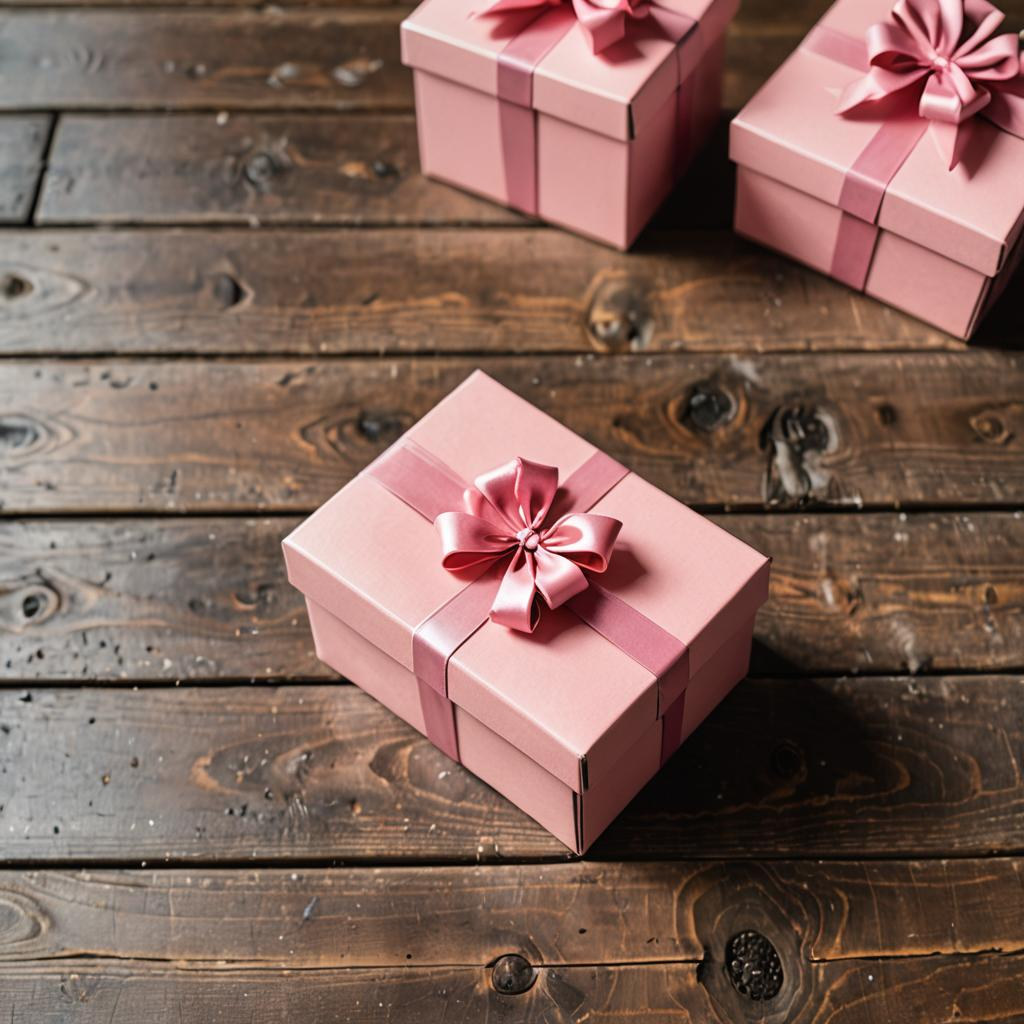

In [27]:
# Second LLM inference for completion
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "photogen"}}]
)

print(completion.choices[0].message.content)

# Display image stored in the file path given by function_result
from PIL import Image
Image.open(function_result)